# Matching input files for SW4 and NonLinLoc: Savard velocity model on Southern Vancouver Island 

This notebook aims to reproduce part of a previous notebook that reformatted a 3D velocity model for Southern Vancouver Island (SVI) into an input file for the software SW4. In this version, I will be using the same velocity model, but the output will include the VGGRID and LABEL lines for the software NonLinLoc. Essentially, this notebook formats the model for both software packages.

NB: The LABEL command for NLLoc gives the Vp, Vs, and ρ gradient for different layers (though no ρ). Since our model have those 3 parameters changing according to lon and lat, I have to choose a way to average it. **CORRECTION:** Since we have a nice model (Savard) we'll be using Trugman method with SimulPS.txt files in model instead of the Vel2Grid with layers.

Watch out for !!, TO-DO, ###.

#### 2nd version of this notebook:
<li> Savard Velocity Model on Southern Vancouver Island</li>
<li> Interpolation of the model in a smaller region</li>
<li> No topo added</li>
<li> No values of density</li>
<li> LAYER defined by mean velocities by slices; not used</li>

In [26]:
import math
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
base_dir = '/Users/lpapin/Documents/phd/projects/sw4/nonlinloc/'

## Prepare the velocity model

### Load the data + some calculations

First, getting the locations of the events and the stations, that will give us the boundaries of the region. From that, I create a subset of the velocity model to not use it fully. I also start to get some values from the model to 1. interpolate and 2. decide how to fix Vp, Vs, and ρ, for the layers in NLLoc.

In [2]:
# Load LFE data on Bostock's catalog
events = pd.read_csv('lfe_svi.txt', index_col=0, dtype={'date': str, 'hour': str, 'lfe_family' : str})
events['date'] = '20' + events['date']
events['date'] = pd.to_datetime(events['date'], format='%Y%m%d')
events['hour'] = events['hour'].str.zfill(2)
events['OT'] = events['date'] + pd.to_timedelta(events['hour'].astype(int), unit='h') + pd.to_timedelta(events['second'], unit='s')
events = events.drop(columns=['hour','second'])
events = events.sort_values(by='OT', ascending=True)
events.reset_index(inplace=True)
events.index.name = 'Index'
print(events)
# Load the locations ###Bostock or Tim's locations idk
sav_family_phases = np.load('sav_family_phases.npy', allow_pickle=True).item()

       lfe_family       date     Mw                      OT
Index                                                      
0             045 2003-02-26  1.513 2003-02-26 00:15:02.050
1             132 2003-02-26  1.516 2003-02-26 00:49:42.850
2             032 2003-02-26  1.516 2003-02-26 01:27:25.575
3             032 2003-02-26  1.583 2003-02-26 01:28:08.375
4             066 2003-02-26  1.850 2003-02-26 01:47:36.225
...           ...        ...    ...                     ...
269418        078 2013-10-13  1.150 2013-10-13 14:30:58.400
269419        275 2013-10-13  1.352 2013-10-13 15:01:46.800
269420        263 2013-10-13  1.360 2013-10-13 15:04:50.000
269421        256 2013-10-13  1.127 2013-10-13 21:20:43.325
269422        295 2013-10-13  1.771 2013-10-13 23:59:29.725

[269423 rows x 4 columns]


In [3]:
# Get the families and match the locations
nb_family = events['lfe_family'].unique()
nb_family.sort()
eventLocs = []
for fam in nb_family:
    eqLoc_values = sav_family_phases[fam]['eqLoc']
    lon_family, lat_family, z_family = eqLoc_values
    lon_family = lon_family * -1
    eventLocs.append([fam, lon_family, lat_family, z_family])
eventLocs = pd.DataFrame(eventLocs, columns=['Index', 'lon', 'lat', 'depth'])
eventLocs.set_index('Index', inplace=True) ###index=family
print(eventLocs)

              lon        lat  depth
Index                              
001   -123.912333  48.418833  32.66
002   -123.588667  48.421833  34.97
003   -123.519667  48.185167  30.08
005   -123.800667  48.479667  34.97
006   -123.940000  48.458333  32.15
...           ...        ...    ...
296   -123.481500  48.392167  37.05
297   -123.528333  48.401667  33.92
298   -123.666833  48.814167  42.18
299   -123.875833  48.872833  40.52
300   -123.921167  48.513000  32.94

[130 rows x 3 columns]


In [4]:
# Get the stations locations
stas=pd.read_csv('stations.csv', usecols=[1, 2, 3, 4],
                    names=['sta', 'lat', 'lon', 'elev'], header=0, delimiter='|')
# Matching the stations with the one used in the picker
stations_to_keep = {'SSIB', 'SILB', 'TSJB', 'TWKB', 'KLNB', 'LZB', 'PGC', 'PFB', 'MGCB', 'NLLB', 'SNB', 'YOUB'}
stas = stas[stas['sta'].isin(stations_to_keep)].reset_index(drop=True)
print(stas)

     sta      lat       lon   elev
0   MGCB  48.6317 -123.6808  236.0
1    LZB  48.6122 -123.8240  794.0
2   NLLB  49.2271 -123.9882  199.0
3    PFB  48.5747 -124.4541  449.0
4    PGC  48.6498 -123.4521   12.0
5    SNB  48.7751 -123.1723  402.0
6   YOUB  48.9010 -124.2618  771.0
7   KLNB  48.6611 -123.5706    0.0
8   SILB  48.6020 -123.2815   76.0
9   SSIB  48.7558 -123.3875   12.0
10  TSJB  48.6013 -123.9885  378.0
11  TWKB  48.6448 -123.7332  128.0


### Plot the events and stations + get the boundaries

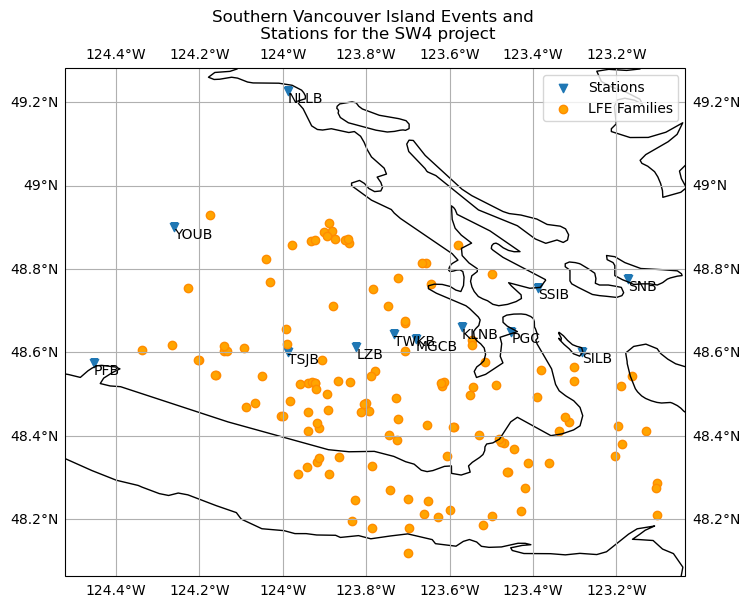

In [5]:
# Plotting the families and the stations
fig=plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(stas['lon'],stas['lat'],marker='v',label='Stations')
[plt.text(i, j, f'{name}',va='top',ha='left') for (i, j,name) in zip(stas['lon'],stas['lat'],stas['sta'])]
plt.scatter(eventLocs['lon'],eventLocs['lat'],marker='o',edgecolors='darkorange',facecolors='orange',label='LFE Families')
ax.legend()
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
plt.title('Southern Vancouver Island Events and \n Stations for the SW4 project')
#plt.savefig(base_dir+'map_evsta_SVI.png', dpi=300)
plt.show()

In [6]:
# Gets the limits of the rectangle that encompasses all of our points plus a little buffer
Plotlims=ax.get_extent()
lonMin_ini, lonMax_ini, latMin_ini, latMax_ini=Plotlims
print(f'{lonMin_ini:.2f}, {lonMax_ini:.2f}, {latMin_ini:.2f}, {latMax_ini:.2f}')

-124.52, -123.03, 48.06, 49.28


### Load the velocity model

In [7]:
# Load the model and get a subset
velmodel=pd.read_csv('Savard_VpVs.txt', sep='\s+',header=None, names=['lon', 'lat', 'depth', 'vp', 'vs', 'DWS'])
velmodel = velmodel.drop(columns=['DWS'])
print(velmodel, '\nbecomes')
velmodel_subset=velmodel[(velmodel['lat']>=latMin_ini)&(velmodel['lat']<=latMax_ini)&(velmodel['lon']<=lonMax_ini)&(velmodel['lon']>=lonMin_ini)]
print(velmodel_subset)

              lon        lat  depth        vp        vs
0     -126.672510  46.951514    0.0  4.956299  2.864755
1     -126.675741  47.077409    0.0  4.966347  2.870762
2     -126.678979  47.203304    0.0  4.976305  2.876411
3     -126.681999  47.320203    0.0  4.968136  2.871618
4     -126.685262  47.446098    0.0  4.957817  2.865878
...           ...        ...    ...       ...       ...
36987 -120.554069  50.494531   93.0  8.245674  4.766323
36988 -120.549634  50.620422   93.0  8.249911  4.768947
36989 -120.545500  50.737325   93.0  8.257427  4.772954
36990 -120.541032  50.863220   93.0  8.261029  4.774880
36991 -120.536556  50.989115   93.0  8.264282  4.776913

[36992 rows x 5 columns] 
becomes
              lon        lat  depth        vp        vs
418   -124.486825  48.183476    0.0  3.422538  1.978356
419   -124.487386  48.300378    0.0  3.399979  1.965315
420   -124.487988  48.426274    0.0  4.170433  2.434671
421   -124.488550  48.543172    0.0  5.085475  3.046571
422   -124.48

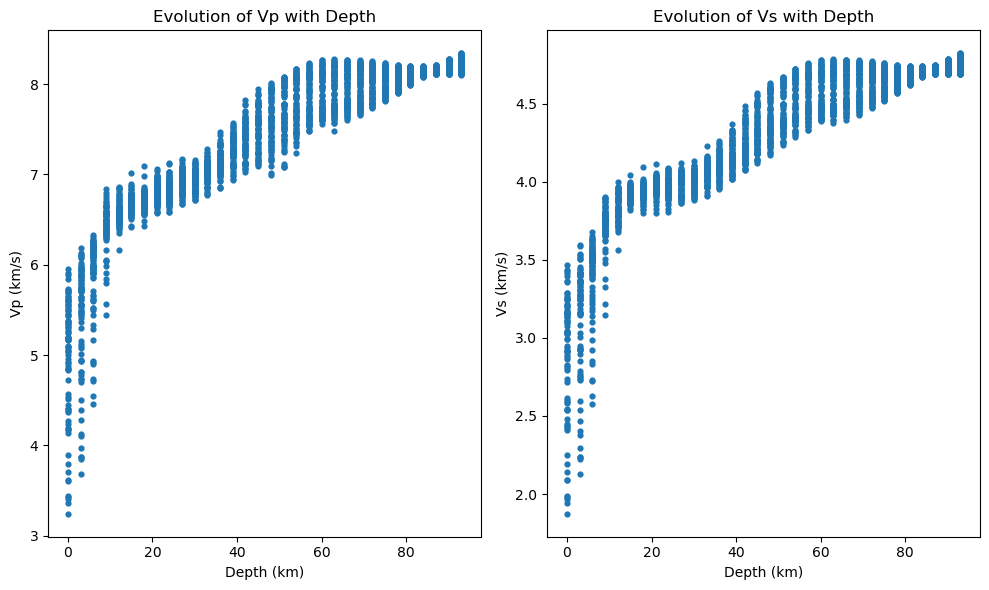

In [8]:
# How the velocities varies with the depth
df = velmodel_subset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.scatter(df['depth'], df['vp'], s=12)
ax1.set_xlabel('Depth (km)')
ax1.set_ylabel('Vp (km/s)')
ax1.set_title('Evolution of Vp with Depth')
ax2.scatter(df['depth'], df['vs'], s=12)
ax2.set_xlabel('Depth (km)')
ax2.set_ylabel('Vs (km/s)')
ax2.set_title('Evolution of Vs with Depth')
plt.tight_layout()
plt.show()

The depth is going every 3km from 0 to 93km (32 values). Note that the velocities are also varying with lon and lat so to create the layer parameters for NonLinLoc I need to decide a way to determine a fixed value.

In [9]:
# Maximum and minimum velocities
print(f"The minimum Vp is {np.min(velmodel_subset['vp']):.2f} km/s and the maximum is {np.max(velmodel_subset['vp']):.2f} km/s.")
print(f"The minimum Vs is {np.min(velmodel_subset['vs']):.2f} km/s and the maximum is {np.max(velmodel_subset['vs']):.2f} km/s.")

The minimum Vp is 3.24 km/s and the maximum is 8.34 km/s.
The minimum Vs is 1.87 km/s and the maximum is 4.82 km/s.


### Interpolation of the velocity model grid

#### Redefine the grid in lat/lon

In [10]:
print(f'{lonMin_ini:.2f}, {lonMax_ini:.2f}, {latMin_ini:.2f}, {latMax_ini:.2f}')

-124.52, -123.03, 48.06, 49.28


The grid is based on the rectangle defined previously for the velocity model subset. The values of lat and lon get a step of 0.02 degrees.

NB: It is originally every 0.1 degrees in the notebook for SW4, !! need to be sure to make the change when using SW4 and verify that it will work.

In [11]:
# Define latitude, longitude, and depth ranges for the grid
latMin, latMax, lonMin, lonMax = 48, 49.3, -124.5, -123
degrees_step = 0.02
lats = 10 * np.arange(latMin, latMax, degrees_step) / 10
lons = 10 * np.arange(lonMin, lonMax, degrees_step) / 10
depths = velmodel['depth'].unique().tolist() # Include stations with elevations #[-3] + 
lon_grid, lat_grid, depth_grid = np.meshgrid(lons, lats, depths)

In [12]:
# Grid defined for the subset
grid = np.vstack([lon_grid.ravel(), lat_grid.ravel(), depth_grid.ravel()]).T

# Interpolating the velocity model 
grid_vp = griddata((velmodel['lon'],velmodel['lat'],velmodel['depth']), velmodel['vp'], 
                    (grid), method='linear')
grid_vs = griddata((velmodel['lon'],velmodel['lat'],velmodel['depth']), velmodel['vs'], 
                    (grid), method='linear')
velmodel_interp = pd.DataFrame(np.hstack((grid,
                                      grid_vp.reshape(len(lats)*len(lons)*len(depths),1),
                                      grid_vs.reshape(len(lats)*len(lons)*len(depths),1))), 
                           columns=['lon', 'lat', 'depth', 'vp', 'vs'])
print(velmodel_interp)

           lon    lat  depth        vp        vs
0      -124.50  48.00    0.0  4.243970  2.453184
1      -124.50  48.00    3.0  4.579647  2.647116
2      -124.50  48.00    6.0  4.929161  2.849226
3      -124.50  48.00    9.0  5.413106  3.128895
4      -124.50  48.00   12.0  5.818082  3.363077
...        ...    ...    ...       ...       ...
155995 -123.02  49.28   81.0  8.044969  4.650182
155996 -123.02  49.28   84.0  8.111004  4.688506
155997 -123.02  49.28   87.0  8.177095  4.726755
155998 -123.02  49.28   90.0  8.248411  4.767953
155999 -123.02  49.28   93.0  8.306332  4.801179

[156000 rows x 5 columns]


In [13]:
# Check for NaN values
vp_nan_count = np.isnan(velmodel_interp['vp']).sum()
vs_nan_count = np.isnan(velmodel_interp['vs']).sum()
assert vp_nan_count == 0 and vs_nan_count == 0, "NaN values found in Vp or Vs. Fix the NaN values before proceeding."

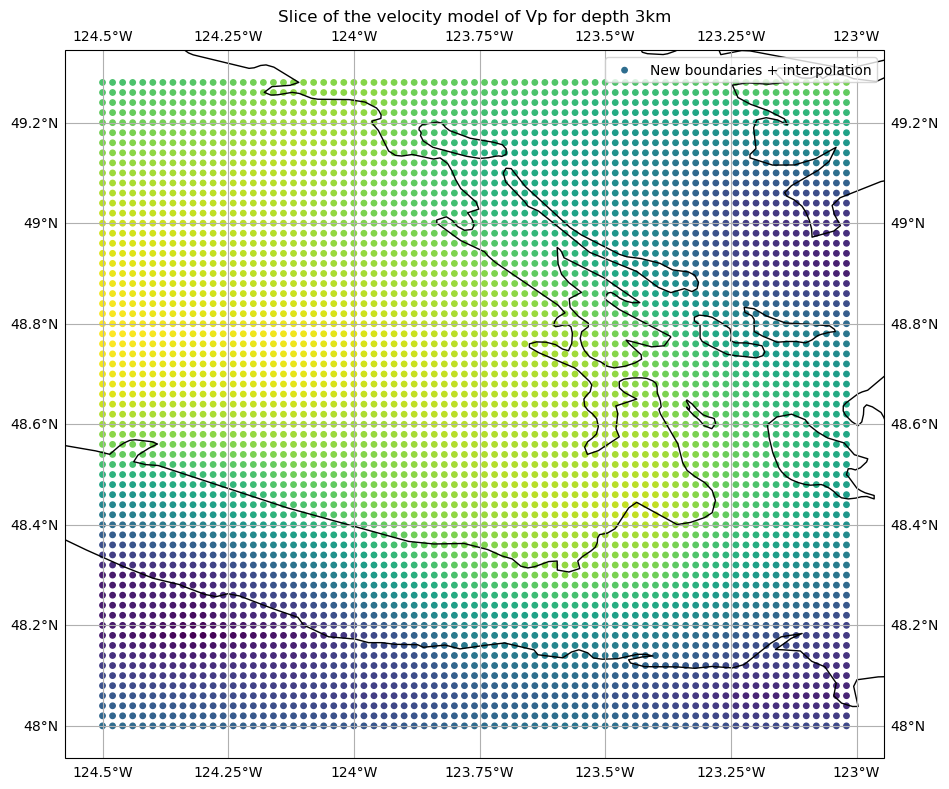

In [14]:
# Example of a slice interpolation
d=3 #depth of the slice
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
dslice=velmodel[velmodel['depth']==d]
#plt.scatter(dslice['lon'],dslice['lat'],20,dslice['vp'], label="Original boundaries")
dslice_interp=velmodel_interp[velmodel_interp['depth']==d]
plt.scatter(dslice_interp['lon'],dslice_interp['lat'],15,dslice_interp['vp'],label="New boundaries + interpolation")
ax.legend()
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
plt.title(f"Slice of the velocity model of Vp for depth {d}km")
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig(base_dir+f'slice_{d}km.png', dpi=300)
plt.show()

Some approximations for the polygon in SimulPS_Vel2Grid notebook. The values are needed in the create_dict_std_param fct.

In [15]:
# Variables of reference
lat_mid = (latMin+latMax)/2 
km_per_degree_lat = 111

# Calculate the distance in latitude (in km)
latitude_step_km = degrees_step * km_per_degree_lat
latitude_distance_km = (latMax - latMin) * km_per_degree_lat

# Calculate the distance in longitude (in km) at the midpoint latitude
longitude_step_km = degrees_step * math.cos(math.radians(lat_mid)) * km_per_degree_lat
longitude_distance_km = (lonMax - lonMin) * math.cos(math.radians(lat_mid)) * km_per_degree_lat

# Output the results
print(f"Latitude step: {latitude_step_km:.2f} km (for ysep)")
print(f"Longitude step: {longitude_step_km:.2f} km (for xsep)")
print(f"Distance between latitudes: {latitude_distance_km:.2f} km (for ymin and ymax)")
print(f"Distance between longitudes: {longitude_distance_km:.2f} km (for xmin and xmax)")

Latitude step: 2.22 km (for ysep)
Longitude step: 1.47 km (for xsep)
Distance between latitudes: 144.30 km (for ymin and ymax)
Distance between longitudes: 110.00 km (for xmin and xmax)


#### Interpolation of the depths

This part gives a step of 1km for the depths instead of 3, and adds 1km of elevation to take into account the stations. 

In [16]:
df_pivot = velmodel_interp.pivot_table(index=['lat', 'lon', 'depth'], values=['vp', 'vs'])
ds = xr.Dataset.from_dataframe(df_pivot).sel(depth=slice(-1, 93)).reindex({"depth": range(-1, 93+1)})
ds_interp = ds.interpolate_na(dim="depth", method="cubic", fill_value="extrapolate")
ds_interp['vs'][0][0]

<xarray.DataArray 'vs' (depth: 95)> Size: 760B
array([2.36607446, 2.45318365, 2.52559133, 2.5885009 , 2.64711575,
       2.70663927, 2.77227485, 2.84922589, 2.94006203, 3.03681796,
       3.12889462, 3.20910107, 3.28387881, 3.36307744, 3.45292259,
       3.54514384, 3.6278468 , 3.69300657, 3.74807635, 3.80437886,
       3.86975046, 3.93808207, 3.99977827, 4.04795885, 4.08660458,
       4.12241148, 4.16030582, 4.19813496, 4.23197655, 4.25940985,
       4.28402068, 4.31089651, 4.34331507, 4.3773151 , 4.40712565,
       4.42837101, 4.44225663, 4.45138324, 4.45822945, 4.46478544,
       4.47291929, 4.48387847, 4.49642809, 4.50871266, 4.51924073,
       4.52797704, 4.53525035, 4.54130232, 4.54602616, 4.54922795,
       4.55087626, 4.5515896 , 4.55214896, 4.55314049, 4.5543711 ,
       4.55545285, 4.55617544, 4.55703907, 4.55872152, 4.56165764,
       4.56531033, 4.56889954, 4.57184105, 4.57433413, 4.57677388,
       4.57944901, 4.58222259, 4.58485127, 4.58721271, 4.58966847,
       4.59270111, 4.59665523, 4.60132362, 4.6063611 , 4.61149201,
       4.61671856, 4.62211247, 4.62771691, 4.63346083, 4.63924467,
       4.64500048, 4.65078685, 4.65669402, 4.66279633, 4.66910456,
       4.67561361, 4.68230736, 4.68912555, 4.69599692, 4.70285211,
       4.70962952, 4.71626945, 4.72271223, 4.72889818, 4.73476759])
Coordinates:
    lat      float64 8B 48.0
    lon      float64 8B -124.5
  * depth    (depth) int64 760B -1 0 1 2 3 4 5 6 7 ... 86 87 88 89 90 91 92 93

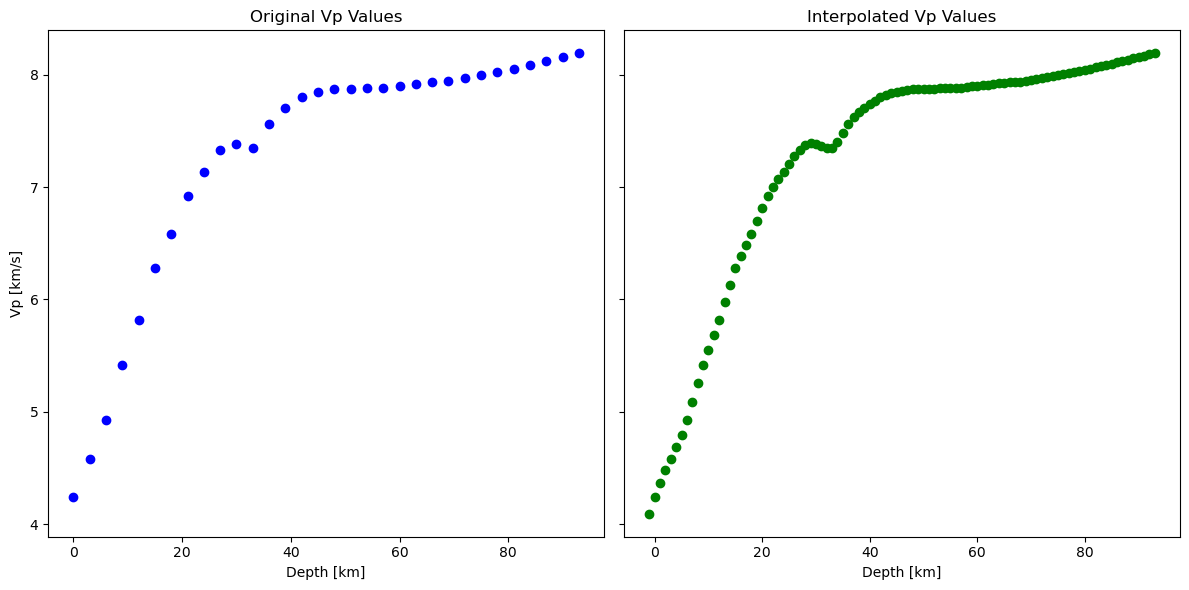

In [17]:
# Selecting based on the first latitude and longitude
vp_original = ds['vp'].sel(lat=ds['lat'][0], lon=ds['lon'][0])
vp_interp = ds_interp['vp'].sel(lat=ds_interp['lat'][0], lon=ds_interp['lon'][0])

# How the velocities got interpolated
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axs[0].scatter(vp_original['depth'], vp_original, color='blue')
axs[0].set_title("Original Vp Values")
axs[0].set_xlabel("Depth [km]")
axs[0].set_ylabel("Vp [km/s]")
axs[1].scatter(vp_interp['depth'], vp_interp, color='green')
axs[1].set_title("Interpolated Vp Values")
axs[1].set_xlabel("Depth [km]")
plt.tight_layout()
plt.show()

### Save the model

In [18]:
# Keep the interpolated one
ds_interp.to_netcdf("velmodel_interp.nc")

## Getting the .ppmod file for SW4

This is for coherence between the velocity model used in NLLoc and the one used after for SW4. The notebook *generate_pfile_VCI.py* is the original code for creating the .ppmod file from the velocity model.

_TO-DO:_ Add the computation of the densities with the function from the SW4 project + modify the writting of the .ppmod.

In [19]:
# No values of dentisities for now
velmodel_interp['rho']=0.0
nb_depths=len(depths)
output_SW4_format='VancouverIsland.ppmod'
for lat in lats:
    for lon in lons:
        tmp=velmodel_interp[(velmodel_interp['lat']==lat) & (velmodel_interp['lon']==lon)]
        tmp.insert(0,'ind',range(1,nb_depths+1)) 
        file=open(output_SW4_format,'a')
        file.write(str(lat)+' '+str(lon)+' '+str(nb_depths)+'\n')
        file.close()
        tmp[['ind','depth','vp','vs','rho']].to_csv(base_dir+output_SW4_format, sep=' ', header=False, index=False, mode='a')
print(f"Data written to {base_dir+output_SW4_format}")

Data written to /Users/lpapin/Documents/phd/projects/sw4/nonlinloc/VancouverIsland.ppmod


## Getting the commands for NLLoc (optional)

!! this part is only used if the LAYER model is gonna be used for the travel-time grids. Stop the process here and use SimulPS_Vel2Grid if not needed

### LAYER command for NLLoc

The LAYER command is defined as follow: LAYER *depth Vp_top Vp_grad Vs_top Vs_grad p_top p_grad*, with 

- depth (float) depth to top of layer (use negative values for layers above z=0);
- VpTop VsTop rhoTop (float) P velocity, and S velocity in km/s and density in kg/m**3 at the top of the layer;
- VpGrad VsGrad rhoGrad (float) Linear P velocity and S velocity gradients in km/s/km and density gradient in kg/m**3/km increasing directly downwards from the top of the layer.

For this reason, I have to define fixed values of Vp and Vs for each depth value. **CORRECTION:** The LAYER command is not interesting in the SVI project because we have a better velocity model and we can use it differently. I'll use parts of Loïc's notebooks to produce a .txt file used by Vel2Grid instead of this. The cells below can still be used for other projects.

In [20]:
# Every slice with Vp and Vs values ###to be run once to get the figures than comment the savefigs
velocities = []
for d in depths:
    d=int(d)
    # Create a figure for Vp
    plt.figure(figsize=(8, 6))
    ax_vp = plt.axes(projection=ccrs.PlateCarree())
    dslice_vp_interp = velmodel_interp[velmodel_interp['depth'] == d]
    sc_vp = plt.scatter(dslice_vp_interp['lon'], dslice_vp_interp['lat'], 20, dslice_vp_interp['vp'], 
                        cmap='viridis', label="New boundaries + interpolation")
    ax_vp.coastlines()
    ax_vp.gridlines(draw_labels=True)
    plt.colorbar(sc_vp, ax=ax_vp, label='Vp (km/s)')
    plt.title(f"Slice of the velocity model of Vp for depth {d}km")
    plt.legend(loc='upper right')
    plt.tight_layout()
    #plt.savefig(base_dir+f'slices/slice_Vp_depth_{d}km.png', dpi=300)
    plt.close()

    # Get the maximum and minimum
    max_vp=np.max(dslice_vp_interp['vp'])
    min_vp=np.min(dslice_vp_interp['vp'])
    mean_vp=np.mean(dslice_vp_interp['vp'])
    median_vp=np.median(dslice_vp_interp['vp'])

    # Create a separate figure for Vs
    plt.figure(figsize=(8, 6))
    ax_vs = plt.axes(projection=ccrs.PlateCarree())
    dslice_vs_interp = velmodel_interp[velmodel_interp['depth'] == d]
    sc_vs = plt.scatter(dslice_vs_interp['lon'], dslice_vs_interp['lat'], 20, dslice_vs_interp['vs'], 
                        cmap='plasma', label="New boundaries + interpolation")
    ax_vs.coastlines()
    ax_vs.gridlines(draw_labels=True)
    plt.colorbar(sc_vs, ax=ax_vs, label='Vs (km/s)')
    plt.title(f"Slice of the velocity model of Vs for depth {d}km")
    plt.legend(loc='upper right')
    plt.tight_layout()
    #plt.savefig(base_dir+f'slices/slice_Vs_depth_{d}km.png', dpi=300)
    plt.close()
    
    # Get the maximum and minimum
    max_vs=np.max(dslice_vs_interp['vs'])
    min_vs=np.min(dslice_vs_interp['vs'])
    mean_vs=np.mean(dslice_vs_interp['vs'])
    median_vs=np.median(dslice_vs_interp['vs'])

    # Append the values to the list as a dictionary; also used pour LAYER
    velocities.append({
        'depth': d,
        'max_vp': max_vp,
        'min_vp': min_vp,
        'mean_vp': mean_vp,
        'median_vp': median_vp,
        'max_vs': max_vs,
        'min_vs': min_vs,
        'mean_vs': mean_vs,
        'median_vs': median_vs,
    })

# Keeping velocities statistics 
velocities = pd.DataFrame(velocities).round(2)

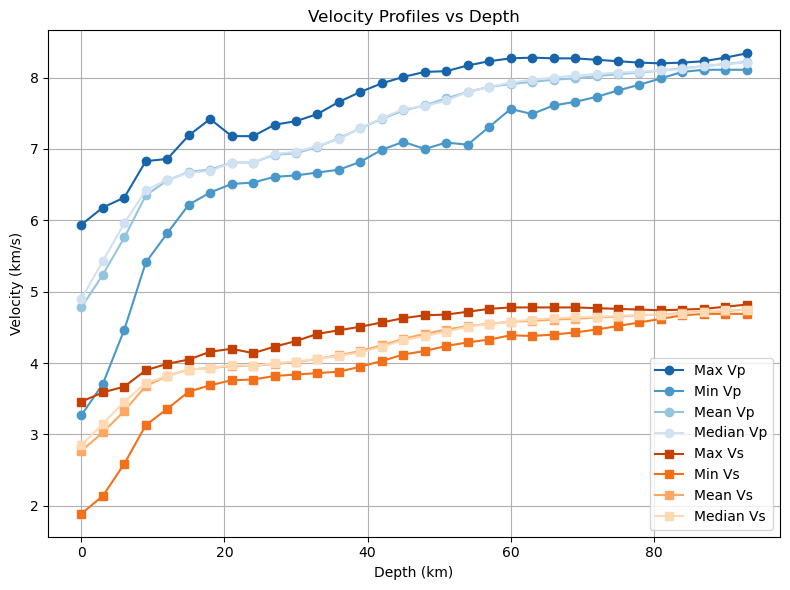

In [21]:
# First let's look at our velocities
df = pd.DataFrame(velocities)
fig, ax = plt.subplots(figsize=(8, 6))
vp_colors = matplotlib.colormaps['Blues']
vs_colors = matplotlib.colormaps['Oranges']
ax.plot(df['depth'], df['max_vp'], label='Max Vp', marker='o', color=vp_colors(0.8))
ax.plot(df['depth'], df['min_vp'], label='Min Vp', marker='o', color=vp_colors(0.6))
ax.plot(df['depth'], df['mean_vp'], label='Mean Vp', marker='o', color=vp_colors(0.4))
ax.plot(df['depth'], df['median_vp'], label='Median Vp', marker='o', color=vp_colors(0.2))
ax.plot(df['depth'], df['max_vs'], label='Max Vs', marker='s', color=vs_colors(0.8))
ax.plot(df['depth'], df['min_vs'], label='Min Vs', marker='s', color=vs_colors(0.6))
ax.plot(df['depth'], df['mean_vs'], label='Mean Vs', marker='s', color=vs_colors(0.4))
ax.plot(df['depth'], df['median_vs'], label='Median Vs', marker='s', color=vs_colors(0.2))
ax.set_xlabel('Depth (km)')
ax.set_ylabel('Velocity (km/s)')
ax.set_title('Velocity Profiles vs Depth')
ax.legend()
ax.grid(True)
plt.tight_layout()
#plt.savefig(base_dir+'vpvs_profiles_vs_depth.png', dpi=300)
plt.show()

The mean and the median for both velocities are pretty close so choosing one or the other won't make much of a difference. <br> The difference between the max and the min is high for Vp for the first 9km (4 slices). Then it gets better with some bigger differences around 50km of depth. Vs keeps a pretty small difference in comparison for all slices specially at the end (makes sense better resolution for small depths).

To begin with, I choose to keep the mean for each depth for Vp and Vs. I'll see later on how to ameliorate these values (*dividing the model?*).

In [22]:
# Getting the velocities and density values
Vp_grad = 0
Vs_grad = 0
p_top = 0
p_grad = 0
layer_data = []
for depth in depths:
    row = velocities[velocities['depth'] == depth]
    mean_vp = row['mean_vp'].values[0]
    mean_vs = row['mean_vs'].values[0]
    layer_data.append({
        'LAYER': 'LAYER', 
        'depth': depth, 
        'Vp_top': mean_vp, 
        'Vp_grad': Vp_grad, 
        'Vs_top': mean_vs, 
        'Vs_grad': Vs_grad, 
        'p_top': p_top, 
        'p_grad': p_grad
    })

# Get a look at the values
layer_data = pd.DataFrame(layer_data)
print(layer_data)

    LAYER  depth  Vp_top  Vp_grad  Vs_top  Vs_grad  p_top  p_grad
0   LAYER    0.0    4.78        0    2.77        0      0       0
1   LAYER    3.0    5.24        0    3.03        0      0       0
2   LAYER    6.0    5.76        0    3.33        0      0       0
3   LAYER    9.0    6.35        0    3.68        0      0       0
4   LAYER   12.0    6.56        0    3.82        0      0       0
5   LAYER   15.0    6.68        0    3.91        0      0       0
6   LAYER   18.0    6.71        0    3.93        0      0       0
7   LAYER   21.0    6.81        0    3.96        0      0       0
8   LAYER   24.0    6.81        0    3.96        0      0       0
9   LAYER   27.0    6.92        0    3.99        0      0       0
10  LAYER   30.0    6.94        0    4.01        0      0       0
11  LAYER   33.0    7.03        0    4.06        0      0       0
12  LAYER   36.0    7.15        0    4.11        0      0       0
13  LAYER   39.0    7.29        0    4.17        0      0       0
14  LAYER 

In [23]:
# Write the LAYER lines for the input NLLoc file for Vel2Grid
output_layer_lines = "LAYER_command.txt"
with open(base_dir+output_layer_lines, "w") as file:
    #file.write("#The values of velocities are the mean over a slice of the subset model used for this.\n")
    #file.write("#LAYER depth Vp_top Vp_grad Vs_top Vs_grad p_top p_grad\n")
    for _, row in layer_data.iterrows():
        layer_line = f"{row['LAYER']} {row['depth']} {row['Vp_top']:.2f} {row['Vp_grad']} {row['Vs_top']:.2f} {row['Vs_grad']} {row['p_top']} {row['p_grad']}\n"
        #file.write(layer_line)
print(f"Data written to {base_dir+output_layer_lines}.")

Data written to /Users/lpapin/Documents/phd/projects/sw4/nonlinloc/LAYER_command.txt.


### VGGRID command for NLLoc 

The VGGRID command is defined as follow: LAYER *depth Vp_top Vp_grad Vs_top Vs_grad p_top p_grad*, with 

- xNum yNum zNum (integer, min:2) number of grid nodes in the x, y and z directions;
- xOrig yOrig zOrig (float) x, y and z location of the grid origin in km relative to the geographic origin;
- dx dy dz (float) grid node spacing in kilometers along the x, y and z axes;
- gridType (choice: VELOCITY VELOCITY_METERS SLOWNESS VEL2 SLOW2 SLOW_2_METERS SLOW_LEN) physical quantity to store on grid (VELOCITY = km/s).

!! the way this line is defined is **wrong** because I am using lat/lon values while the command ask for km values. In the SimulPS_Vel2Grid notebook the velocity model is projected in cartesian coordinates and the values needed for this command can be taken there. Still letting this cell here as it might help for another time.

In [24]:
lon_unique=velmodel_interp['lon'].unique()
lat_unique=velmodel_interp['lat'].unique()

# How many grid nodes
xNum = len(lon_unique)
yNum = len(lat_unique)
zNum = len(depths)
print('Number of grid nodes:',xNum,yNum,zNum)

# Location of the grid origin in km relative to the geographic origin
### need to correct this
xOrig = velmodel_interp['lon'].min()
yOrig = velmodel_interp['lat'].min()
zOrig = depths[0]
print('Grid origin in km:',xOrig,yOrig,zOrig)

# Grid node spacing from degrees to km
dx_deg = lon_unique[1] - lon_unique[0]
dx = 7.5 * dx_deg # 7.5km defined for 0.1 degrees of longitude at latitude 47.7
dy_deg = lat_unique[1] - lat_unique[0]
dy = 11.1 * dy_deg
dz = depths[1] - depths[0]
print('Grid node spacing:',f'{dx:0.2f}',f'{dy:0.2f}',dz)

# Determine grid type
gridType = 'VELOCITY'

# Get a look at the values
print(f"VGGRID {xNum} {yNum} {zNum} {xOrig} {yOrig} {zOrig} {dx:0.2f} {dy:0.2f} {dz} {gridType}")

Number of grid nodes: 75 65 32
Grid origin in km: -124.5 48.0 0.0
Grid node spacing: 0.15 0.22 3.0
VGGRID 75 65 32 -124.5 48.0 0.0 0.15 0.22 3.0 VELOCITY


In [25]:
# Write the LAYER lines for the input NLLoc file for Vel2Grid
output_layer_lines = "VGGRID_command.txt"
with open(base_dir+output_layer_lines, "w") as file:
    #file.write("#VGGRID xNum yNum zNum xOrig yOrig zOrig dx dy dz gridType\n")
    vggrid_line = f"VGGRID {xNum} {yNum} {zNum} {xOrig} {yOrig} {zOrig} {dx:0.2f} {dy:0.2f} {dz} {gridType} \n"
    #file.write(vggrid_line)
print(f"Data written to {base_dir+output_layer_lines}.")

Data written to /Users/lpapin/Documents/phd/projects/sw4/nonlinloc/VGGRID_command.txt.
